In [66]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

In [67]:
# Importing Data
raw_data = pd.read_pickle("pkl files/raw_data.pkl")
print(raw_data.columns.values)

['exp_no' 'activity' 'PWR_ch1' 'PWR_ch2' 'PWR_ch3']


In [68]:
# Flattening channels
channels = ['PWR_ch1', 'PWR_ch2', 'PWR_ch3']
for channel in channels:
    raw_data[channel] = raw_data[channel].apply(
        lambda x: np.array(x).flatten()
    )

In [69]:
# Sample printing
print(type(raw_data))
print(type(raw_data['PWR_ch1']))
print(type(raw_data.iloc[0]['PWR_ch1']))
print(raw_data.iloc[0]['PWR_ch1'][:20])

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
[0.       0.020264 0.007294 0.001887 0.004463 0.000502 0.00028  0.007239
 0.006811 0.004608 0.000545 0.000668 0.004954 0.006757 0.003506 0.002638
 0.001525 0.003001 0.002325 0.001983]


In [70]:
# Replace all zero values with min value for log calculations
# And Decibel calculations
for channel in channels:
    ch_values = raw_data[channel].to_numpy()
    # Flatten nested lists if needed:
    # ch_values = np.array([np.array(x) for x in ch_values])

    # Calculate minimum non-zero value per row
    min_gt = np.array([
        np.ma.array(ch, mask=(ch == 0)).min() for ch in ch_values
    ])

    # Replace zeros with corresponding min values
    raw_data[channel] = [
        np.where(ch == 0, m, ch) for ch, m in zip(ch_values, min_gt)
    ]
    
    # Log for decibel
    raw_data[channel] = raw_data[channel].apply(lambda x: 20*np.log10(x))

In [71]:
# Opening length of each experiment data
with open("pkl files/lenDict.pkl", "rb") as f:
    lenDict = pickle.load(f)

lengths = lenDict.values()

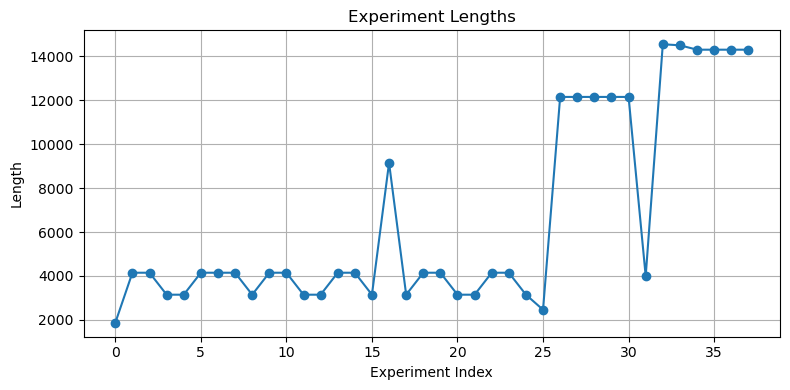

In [72]:
plt.figure(figsize=(8, 4))
plt.plot(lengths, marker='o')
plt.title("Experiment Lengths")
plt.xlabel("Experiment Index")
plt.ylabel("Length")
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
print(raw_data['activity'].value_counts())

activity
noactivity      150278
walk             37308
bodyrotate       30160
liedown           8349
standfromlie      8173
sit               7903
stand             7730
Name: count, dtype: int64


In [74]:
# Find changes in activity
change_points = raw_data['activity'] != raw_data['activity'].shift()

# Assign block_ids for each change
raw_data['block_id'] = change_points.cumsum()

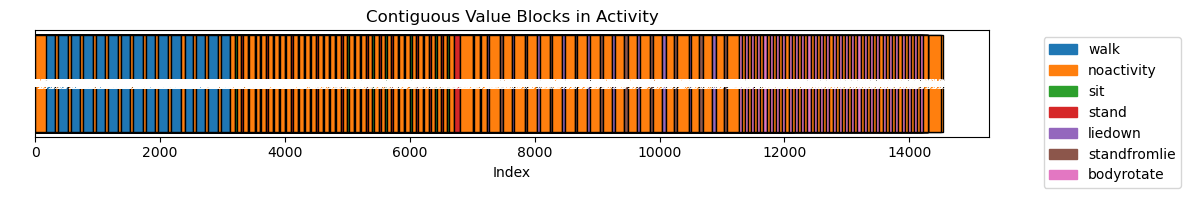

In [75]:
# Unique colour per activity
unique_vals = raw_data['activity'].unique()
color_map = {val: f'C{i}' for i, val in enumerate(unique_vals)}

# Plot
plt.figure(figsize=(12, 2))
for block_id, group in raw_data.groupby('block_id'):
    start = group.index.min()
    end = group.index.max()
    val = group['activity'].iloc[0]
    plt.barh(
        y=[0],
        width=[end - start + 1],
        left=[start],
        color=color_map[val],
        edgecolor='k'
    )
    plt.text((start + end) / 2, 0, val, ha='center', va='center', color='white', fontsize=8)

# Legend
legend_handles = [mpatches.Patch(color=color_map[val], label=val) for val in unique_vals]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.yticks([])
plt.xlabel('Index')
plt.title('Contiguous Value Blocks in Activity')
plt.tight_layout()
plt.savefig("output_images/contiguousblocks.png")
plt.show()


In [76]:
# Measure length of each block
block_lengths = raw_data.groupby(['block_id', 'activity']).size().reset_index(name='length')
print(f"Mean block length = {np.mean(block_lengths['length'])}")

Mean block length = 72.43507246376812


C:\Users\kiran\AppData\Local\Temp\ipykernel_24780\3861628234.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=flat_df, x='activity', y='length', scale='width', inner='quartile')


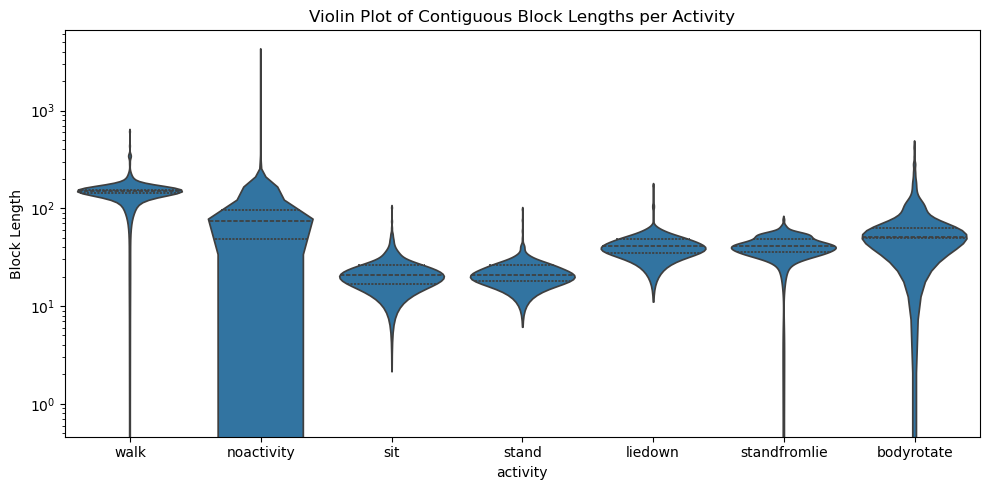

In [77]:
# Flatten for seaborn
flat_df = block_lengths[['activity', 'length']]

plt.figure(figsize=(10, 5))
sns.violinplot(data=flat_df, x='activity', y='length', scale='width', inner='quartile')
plt.yscale('log')  # Optional
plt.ylabel('Block Length')
plt.title('Violin Plot of Contiguous Block Lengths per Activity')
plt.tight_layout()
plt.savefig("output_images/contiguousblocksViolin.png")
plt.show()


In [87]:
# Splitting the spectrograms into equal chunks so that same exp_no in chunks
def chunk_dataframe(df, chunk_size):
    chunks = []

    # Group by both 'exp_no' and 'activity' to preserve uniformity within chunks
    for (exp_no, activity), group in df.groupby(['exp_no', 'activity']):
        rows = len(group)
        full_chunks = rows // chunk_size

        for i in range(full_chunks):
            chunk = group.iloc[i * chunk_size : (i + 1) * chunk_size].copy()
            chunks.append(chunk)

    return chunks

In [88]:
lens = []
for i in tqdm(range(10, 250)):
    chunk_size = i
    chunks = chunk_dataframe(raw_data, chunk_size)
    lens.append(len(chunks))

100%|██████████| 240/240 [04:15<00:00,  1.06s/it]


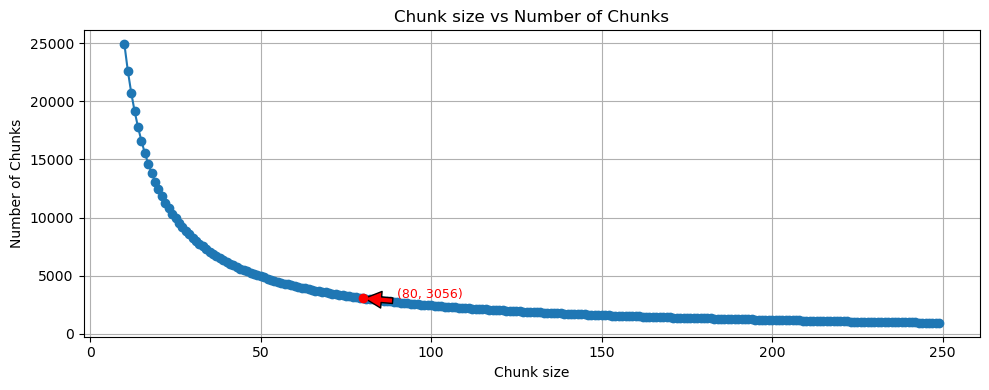

In [89]:
x_values = range(10, 10 + len(lens))  # start at 10

# Index of the point you want to highlight (e.g., third point)
highlight_index = 70

# Plot everything
plt.figure(figsize=(10, 4))
plt.plot(x_values, lens, marker='o', linestyle='-')

# Highlight one point
x_highlight = x_values[highlight_index]
y_highlight = lens[highlight_index]

plt.scatter([x_highlight], [y_highlight], color='red', zorder=5)
plt.annotate(f'({x_highlight}, {y_highlight})',
             xy=(x_highlight, y_highlight),
             xytext=(x_highlight + 10, y_highlight + 1),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=9, color='red')

# Labels and formatting
plt.xlabel("Chunk size")
plt.ylabel("Number of Chunks")
plt.title("Chunk size vs Number of Chunks")
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
chunk_size = 80
chunks = chunk_dataframe(raw_data, chunk_size)

In [ ]:
# We have 3098 equi-width chunks to train the VQVAE
print(type(chunks[0]))
print(len(chunks))

<class 'pandas.core.frame.DataFrame'>
3056
1768    noactivity
1769    noactivity
1770    noactivity
1771    noactivity
1772    noactivity
           ...    
1843    noactivity
1844    noactivity
1845    noactivity
1846    noactivity
1847    noactivity
Name: activity, Length: 80, dtype: object


In [108]:
count = 0
for i in chunks:
    l = i['activity'].to_list()
    for item in l:
        if item != l[0]:
            count+=1

In [109]:
import pickle

with open("pkl files/chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)